# Injecting Synthetic Sources Into Single-Visit Images

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">
<br>
Contact author(s): Jeff Carlin <br>
Last verified to run: 2023-12-15 <br>
LSST Science Pipelines version: Weekly 2023_47 <br>
Container Size: medium <br>
Targeted learning level: intermediate <br>

**Description:** This tutorial demonstrates a method to inject artificial sources (stars and galaxies) into calexp images using the measured point-spread function of the given calexp image. Confirmation that the synthetic sources were correctly injected into the image is done by running a difference imaging task from the pipelines. It then shows how to run the pipelines' detection and measurement tasks on these images, extract the measurements of the artificial stars, and compare their measured magnitudes to the input (simulated) magnitudes.

**Skills:** Use the `source_injection` tools.

**LSST Data Products:** _List the all of the types of LSST catalogs and images used._

**Packages:** _List the python packages used._ (_List the packages being taught first, e.g., afwDisplay for a notebook about displaying images. Then supporting packages, e.g., lsst.daf.butler for a notebook about displaying images. It is OK to leave out basic support packages like os or glob.)_

**Credit:**
Developed by Jeff Carlin in collaboration with the Rubin Community Science Team. Much of the material is based on the [source_injection package documentation](https://pipelines.lsst.io/v/daily/modules/lsst.source.injection/index.html).

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>
and <a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>.
Questions are welcome as new topics in the 
<a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> 
of the Rubin Community Forum. 
Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook provides a brief introduction to the `source_injection` package from the LSST Science Pipelines. The `source_injection` tools can be used to inject sources into images produced during various stages of Pipelines processing, including visit-level images (e.g., `calexp`s), any dataset with a `datasetType` of `Exposure` (e.g., `postISRCCD` images), and coadd images (e.g., `deepCoadd`s). The main driver that both creates and injects synthetic sources into images is based on [Galsim](https://galsim-developers.github.io/GalSim/), so that the `source_injection` tools enable injection of a variety of types of sources. These include a variety of parameterized galaxy models, stars, and postage stamp images.

This notebook will teach users some basics of using the `source_injection` package to insert artificial sources into images, but users are encouraged to read the extensive [documentation](https://pipelines.lsst.io/v/daily/modules/lsst.source.injection/index.html) for more details and examples. Furthermore, the [Galsim](https://galsim-developers.github.io/GalSim/) documentation provides much more detail on the variety of types of sources that can be injected.

For detection and measurement of injected sources, this notebook relies on DP0.2 tutorial [Notebook 05: Introduction to Source Detection](https://github.com/rubin-dp0/tutorial-notebooks/blob/main/DP02_05_Introduction_to_Source_Detection.ipynb). Readers are referred to that notebook for more details on detection and measurement of sources in images.

### 1.1 Import packages

_All package imports should be done in the first code cell._

_Do not import packages unless they are used._

_Provide explanation or external links to package documentation, where appropriate._

_Describe the packages being imported, as is done below for commonly-imported packages._

`numpy` is a fundamental package for scientific computing with arrays in Python
(<a href="https://numpy.org">numpy.org</a>).

`matplotlib` is a comprehensive library for creating static, animated, and
interactive visualizations in Python 
(<a href="https://matplotlib.org/">matplotlib.org</a>; 
<a href="https://matplotlib.org/stable/gallery/index.html">matplotlib gallery</a>).

From the `lsst` package, modules for accessing the TAP service, the butler, and image display functions are imported (<a href="https://pipelines.lsst.io/">pipelines.lsst.io</a>).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from astropy.io import fits
import astropy.units as u
from astropy.table import Column, Table, vstack
from astropy.coordinates import SkyCoord
from scipy.ndimage import gaussian_filter
from dustmaps.sfd import SFDQuery

from lsst.afw.table import SourceTable
from lsst.daf.base import PropertyList
from lsst.daf.butler import Butler, DimensionUniverse, DatasetType, CollectionType
from lsst.daf.butler.registry import MissingCollectionError
import lsst.afw.display as afwDisplay
from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig

# Import tasks from the LSST Science Pipelines for reprocessing images
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

afwDisplay.setDefaultBackend('matplotlib')

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-8.0.0/Linux64/dustmaps_cachedata/gbb0a0c949e+81bc2a20b4/config/.dustmapsrc


### 1.2 Define functions and parameters

_If your notebook defines functions or parameters to use later or throughout, do it here in sub-section 1.2._

_It is OK to rename the subsection to be more specific to the notebook, and/or to use sub-sub-sections like "1.2.1 Define global cosmological parameter values" or "1.2.2 Define a function to make an image cutout"._

_It is OK to remove this sub-section if it is not being used._

In [2]:
def processInjected(calexp_inp_new):
    """
    Run source detection, characterization, and measurement
    tasks on an input calexp image with injected synthetic sources.

    Adapted from DP0.2 Notebook 05: Intro to Source Detection.

    Parameters
    ----------
    calexp_inp_new: 'calexp' image
        The calexp image after source_injection has been run

    Returns
    -------
    source_tab: Astropy Table
        A source table with measurements of all detected and 
        deblended sources from the input source-injected calexp
    """
    
    # Create a basic schema to use with these tasks
    schema = SourceTable.makeMinimalSchema()

    # Create a container which will be used to record metadata about algorithm execution
    algMetadata = PropertyList()

    # Initialize CharacterizeImageTask and its configuration:
    config = CharacterizeImageTask.ConfigClass()
    config.psfIterations = 1
    charImageTask = CharacterizeImageTask(None, config=config)

    # Initialize SourceDetectionTask and its configuration:
    config = SourceDetectionTask.ConfigClass()
    config.thresholdValue = 5      # detection threshold in units of thresholdType
    config.thresholdType = "stdev"   # units for thresholdValue
    sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
    sourceDeblendTask = SourceDeblendTask(schema=schema)

    # Initialize SingleFrameMeasurementTask and its configuration:
    config = SingleFrameMeasurementTask.ConfigClass()
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config, algMetadata=algMetadata)

    # Make an empty table that we'll put the results in:
    tab = SourceTable.make(schema)
    
    # Image characterization
    result = charImageTask.run(calexp_inp_new)

    # Get the PSF and some image properties
    psf = calexp_inp_new.getPsf()
    # sigma = psf.computeShape().getDeterminantRadius()
    pixelScale = calexp_inp_new.getWcs().getPixelScale().asArcseconds()

    # The factor of 2.355 converts from std to fwhm
    sigma = 1./pixelScale/2.355
    print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))
    
    # Run source detection
    result = sourceDetectionTask.run(tab, calexp_inp_new)
    
    sources = result.sources

    del result

    sources = sources.copy(True)
    
    # Run source deblending
    sourceDeblendTask.run(calexp_inp_new, sources)

    # Run source measurement
    sourceMeasurementTask.run(measCat=sources, exposure=calexp_inp_new)
    
    # The copy makes sure that the sources are sequential in memory
    sources = sources.copy(True)
    
    # For convenience, return an Astropy table:
    source_tab = sources.asAstropy()
    
    # Convert fluxes to magnitudes and add them to the table
    photocalib = calexp_inp_new.getPhotoCalib()
    psfmags = photocalib.instFluxToMagnitude(sources, 'base_PsfFlux')
    source_tab.add_columns([psfmags[:,0], psfmags[:,1]], names=['mag_psf', 'magerr_psf'])
    
    return(source_tab)

In [3]:
plt.style.use('tableau-colorblind10')

## 2. Get an image to inject sources into:

We must first retrieve an image that we will inject sources into. In this section, we will instantiate a Butler pointing to the DP0.2 dataset, identify `calexp` images overlapping a particular `tract`, and retrieve one of those images (plus some of its ancillary data) for later use.

### 2.1 Instantiate a butler

In [4]:
butler_config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = Butler(butler_config, collections=collections)

### 2.2 Identify images overlapping a particular tract and select one

We choose to select images from tract 3828, but feel free to change this to any tract number that exists in DP0.2 data. (See the map in Figure 15 of ["The DC2 Simulated Sky Survey"](https://ui.adsabs.harvard.edu/abs/2021ApJS..253...31L/abstract) overview paper; also visible in the [DP0.2 documentation](https://dp0-2.lsst.io/data-products-dp0-2/index.html#images)).

Because a `calexp` image only spans one detector, we randomly select a detector (number 19) and find images from the chosen tract that contain that detector.

In [5]:
tract = 3828
where = f"instrument='LSSTCam-imSim' AND skymap='DC2' AND tract={tract} AND detector=19 AND band='g'"

calexp_g_DatasetRefs = sorted(list(set(butler.registry.queryDatasets('calexp', where=where))))

print(f'Identified {len(calexp_g_DatasetRefs)} calexp DatasetRefs')

# Here we use the index "5" to select a random dataId.
# Change this index to select a different image.
dataId_g = calexp_g_DatasetRefs[5].dataId

print(f"{dataId_g = }")

Identified 23 calexp DatasetRefs
dataId_g = {instrument: 'LSSTCam-imSim', detector: 19, visit: 400440, band: 'g', physical_filter: 'g_sim_1.4', visit_system: 1}


#### 2.2.1 Retrieve the calexp image we have identified

In [6]:
calexp_g = butler.get('calexp', dataId=dataId_g)

#### 2.2.2 Retrieve additional information about the image

To generate synthetic sources to be injected into the image, we will need to know the coordinates of its bounding box. Retrieve the image's WCS and bounding box, and print its central coordinate to the screen:

In [7]:
wcs = calexp_g.getWcs()
bbox = calexp_g.getBBox()
print('bounding box: ', bbox)

boxcen = bbox.getCenter()
cen = wcs.pixelToSky(boxcen)
sc_cen = SkyCoord(ra=cen[0].asDegrees()*u.deg, dec=cen[1].asDegrees()*u.deg)

print(sc_cen)

bounding box:  (minimum=(0, 0), maximum=(4071, 3999))
<SkyCoord (ICRS): (ra, dec) in deg
    (56.55131893, -36.42591029)>


#### 2.2.3 Figure out how large the image is on the sky

Note that above the bounding box is roughly 4000 x 4000. Use the `bbox.getDimensions` and `wcs.getPixelScale` methods to estimate how large this image is in sky coordinates:

In [8]:
imsize = bbox.getDimensions()[0]*wcs.getPixelScale().asDegrees()
print('Size of calexp in degrees: ', imsize)

Size of calexp in degrees:  0.22586221347938068


## 3. Make and ingest a catalog of synthetic sources:

We now have a `calexp` image that we want to inject into. Next we need to set up a simple synthetic source catalogue.

### 3.1 Make a catalog of galaxies and stars

The `source_injection` package provides tools to create catalogs of synthetic sources. Here, we will use the `generate_injection_catalog` tool to create the sources we wish to inject.

Note that the "inject_size" is selected to be 0.1 degrees, or slightly smaller than the size of the image as determined above (inject_size is a radius, so it equals 0.2/2 degrees).

In [9]:
inject_size = 0.2/2 # in degrees

#### 3.1.1 Make a catalog of galaxies to inject

The simplest form of a galaxy in Galsim is parameterized by a [Sersic model](https://en.wikipedia.org/wiki/S%C3%A9rsic_profile): $I(r) = I_e~{\rm exp}\{-b_n [(\frac{r}{r_e})^{1/n}-1]\}$, which defines the shape of the galaxy's light profile as a function of radius (r) in terms of the "Sersic index" (n) and the "half-light radius" ($r_e$). (Note that $n = 1$ corresponds to an exponential profile.)

The above equation results in a circular galaxy. One can also specify the minor-to-major axis ratio (q) to create elongated (elliptical) Sersic profiles, with a rotation angle (beta).

The `generate_injection_catalog` task will automatically generate sources with all possible permutations of the parameters you provide. For example, below we specify "number=2" to create 2 synthetic galaxies, but then specify a single magnitude (mag), 3 values of Sersic index (n), 3 values of axis ratio (q), 2 values of beta, and a single value for half_light_radius. This should result in $2*1*3*3*2*1 = 36$ different combinations of those parameters.

Finally, note that we provide minimum and maximum RA and Dec coordinates. In this case, `generate_injection_catalog` will randomly select positions within those limits.

In [10]:
my_injection_catalog_galaxies = generate_injection_catalog(
    ra_lim=[sc_cen.ra.value-inject_size, sc_cen.ra.value+inject_size],
    dec_lim=[sc_cen.dec.value-inject_size, sc_cen.dec.value+inject_size],
    number=2,
    seed='321',
    source_type="Sersic",
    mag=[15.0],
    n=[1, 2, 4],
    q=[0.9, 0.5, 0.1],
    beta=[31.0, 144.0],
    half_light_radius=[15.0],
)

#### 3.1.2 Make a catalog of stars to inject

Using a similar method, create a catalog of stars to be injected. Specify 5 values of magnitude, with 7 instances, which will result in 35 stars.

In [11]:
my_injection_catalog_stars = generate_injection_catalog(
    ra_lim=[sc_cen.ra.value-inject_size, sc_cen.ra.value+inject_size],
    dec_lim=[sc_cen.dec.value-inject_size, sc_cen.dec.value+inject_size],
    number=7,
    seed='432',
    source_type="Star",
    mag=[16.0, 17.0, 18.0, 19.0, 20.0],
)

#### 3.1.3 Combine the galaxies and stars into a single synthetic source catalog

In particular, use the [vstack](https://docs.astropy.org/en/stable/table/operations.html#id4) method from Astropy's [Table](https://docs.astropy.org/en/stable/table/index.html) class to combine them.

In [12]:
inject_cat = vstack([my_injection_catalog_galaxies, my_injection_catalog_stars])

In [13]:
inject_cat

injection_id,ra,dec,source_type,mag,n,q,beta,half_light_radius
int64,float64,float64,str6,float64,int64,float64,float64,float64
0,56.58396293325072,-36.41116416084389,Sersic,15.0,1,0.9,31.0,15.0
1,56.49646293325072,-36.406225889238954,Sersic,15.0,1,0.9,31.0,15.0
10,56.54021293325072,-36.41363329664636,Sersic,15.0,1,0.9,144.0,15.0
11,56.50271293325072,-36.50252218553525,Sersic,15.0,1,0.9,144.0,15.0
20,56.64021293325072,-36.48029996331303,Sersic,15.0,1,0.5,31.0,15.0
21,56.51833793325072,-36.47783082751056,Sersic,15.0,1,0.5,31.0,15.0
30,56.62771293325072,-36.39881848183154,Sersic,15.0,1,0.5,144.0,15.0
31,56.57146293325072,-36.4506703336834,Sersic,15.0,1,0.5,144.0,15.0
40,56.61521293325072,-36.458077741090804,Sersic,15.0,1,0.1,31.0,15.0


### 3.2 Add a postage stamp of an image to the injection catalog

In addition to parameterized sources of many types, a postage-stamp image (for example, an output image from a simulation) can also be injected. The image must be in FITS format. In this notebook, we select an [SDSS g-band image](https://ned.ipac.caltech.edu/byname?objname=NGC+4152&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1) downloaded from the NASA/IPAC Extragalactic Database (NED).

Load the image, then display it to see what it depicts:

In [14]:
stamp_img_hdu = fits.open('PGC_038749_I_g_bbl2011.fits')

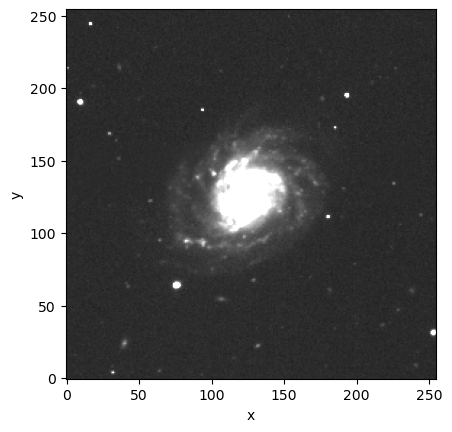

In [15]:
fig = plt.figure()
plt.subplot()
im = plt.imshow(stamp_img_hdu[0].data, cmap='gray', vmin=-20.0, vmax=100, origin='lower')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### 3.2.1 Create an entry in the injection catalog for the postage stamp image

Add a postage stamp entry into the injection catalog, using `vstack` to add an astropy `Table` containing a single row.

In [16]:
my_injection_catalog_stamp = Table(
    {
        'injection_id': [9999],
        'ra': [56.622],
        'dec': [-36.488],
        'source_type': ['Stamp'],
        'mag': [14.8],
        'stamp': ['PGC_038749_I_g_bbl2011.fits'],
    }
)

In [17]:
inject_cat = vstack([inject_cat, my_injection_catalog_stamp])

In [18]:
inject_cat

injection_id,ra,dec,source_type,mag,n,q,beta,half_light_radius,stamp
int64,float64,float64,str6,float64,int64,float64,float64,float64,str27
0,56.58396293325072,-36.41116416084389,Sersic,15.0,1,0.9,31.0,15.0,--
1,56.49646293325072,-36.406225889238954,Sersic,15.0,1,0.9,31.0,15.0,--
10,56.54021293325072,-36.41363329664636,Sersic,15.0,1,0.9,144.0,15.0,--
11,56.50271293325072,-36.50252218553525,Sersic,15.0,1,0.9,144.0,15.0,--
20,56.64021293325072,-36.48029996331303,Sersic,15.0,1,0.5,31.0,15.0,--
21,56.51833793325072,-36.47783082751056,Sersic,15.0,1,0.5,31.0,15.0,--
30,56.62771293325072,-36.39881848183154,Sersic,15.0,1,0.5,144.0,15.0,--
31,56.57146293325072,-36.4506703336834,Sersic,15.0,1,0.5,144.0,15.0,--
40,56.61521293325072,-36.458077741090804,Sersic,15.0,1,0.1,31.0,15.0,--


### 3.3 Ingest the synthetic source catalog into a Butler collection

#### 3.3.1 Register the source injection collection
The input `inject_cat` will be ingested into a RUN collection called `u/{user}/test0_injection_inputs` (where "user" will be your username) in the Butler repository. Here we register this collection for subsequent use below.

To begin, we first instantiate a writable `butler`. Butlers are instantiated in read-only mode by default. By setting the argument `writeable` to `True`, a butler can also be made to be writeable.

> Warning: take care when working with a writeable butler, as data on-disk has the potential to be permanently removed or corrupted.

As a precaution, we attempt to remove our chosen RUN collection if it exists before continuing with processing. If we attempt to inject synthetic sources into a collection that already exists, the task will complain that the output data already exist on disk.

In [19]:
# Get username.
user = os.getenv("USER")

INJECTION_CATALOG_COLLECTION=f"u/{user}/test0_injection_inputs"

# Instantiate a writeable Butler.
writeable_butler =  Butler(butler_config, writeable=True)

try:
    writeable_butler.removeRuns([INJECTION_CATALOG_COLLECTION])
except MissingCollectionError:
    print(f"Writing into a new RUN collection: {INJECTION_CATALOG_COLLECTION}")
    pass
else:
    print(f"Prior RUN collection ({INJECTION_CATALOG_COLLECTION}) located and successfully removed")

Prior RUN collection (u/lskelvin/test0_injection_inputs) located and successfully removed


Now ingest the catalog of synthetic sources into the Butler collection using the `ingest_injection_catalog` method:

In [20]:
my_injected_datasetRefs = ingest_injection_catalog(
    writeable_butler=writeable_butler,
    table=inject_cat,
    band="g",
    output_collection=INJECTION_CATALOG_COLLECTION,
)

## 4. Inject sources into a calexp image

### 4.1 Use source_injection tools to inject sources

The catalog specifying synthetic sources has been ingested into the butler. Now we can run the task from `source_injection` that injects sources into the `calexp` image that we retrieved.

First, extract the point spread function (PSF), photometric calibration object, and the WCS (World Coordinate System) objects associated with the `calexp` image. These will be passed to the injection task so that sources can be injected using the properties of the image itself.

In [21]:
psf = calexp_g.getPsf()
photo_calib = calexp_g.getPhotoCalib()
wcs = calexp_g.getWcs()

Load the input injection catalogs that we ingested into the butler in the previous step.

In [22]:
# Load input injection catalogs.
injection_refs = butler.registry.queryDatasets(
    "injection_catalog",
    band="g",
    collections=INJECTION_CATALOG_COLLECTION,
)
injection_catalogs = [
    butler.get(injection_ref) for injection_ref in injection_refs
]

### 4.2 Instantiate the injection classes

At this stage, we have an input image and we have a fully ingested synthetic source input catalog. We're now ready to inject synthetic sources into the image using the tools available in the `source_injection` repo.

First, instantiate the `VisitInjectConfig` class. The `VisitInjectConfig` class is where configuration of the injection task occurs, allowing for modifications to be made to how the task operates.

Then instantiate the `VisitInjectTask`, using `inject_config` as the configuration argument.

NOTE: For injections into other dataset types, use the appropriate option from the following list:
```
from lsst.source.injection import ExposureInjectConfig,ExposureInjectTask
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.source.injection import CoaddInjectConfig,CoaddInjectTask
```

In [23]:
inject_config = VisitInjectConfig()
inject_task = VisitInjectTask(config=inject_config)

### 4.3 Inject sources into an image

Next, we execute the `run` method of the `inject_task`.

The `run` method needs the following inputs:

* the input injection catalogue
* the input exposure
* the PSF of the input exposure
* the WCS information
* the photometric calibration information

We got the PSF, WCS, and photo_calib inputs directly from the `calexp` they are associated with.

The inject task provides two outputs:

* the output exposure with sources injected
* the output source injection catalogue

The output source injection catalogue is identical to the input, excepting two additional columns (x and y) which denote the pixel coordinates of these sources. Note that this catalogue is NOT the science catalogue containing the full suite of LSST Science Pipelines outputs. To get that, this source injected image will need to be processed by additional Science Pipelines tasks (we show an example of this later in this notebook).

> Note: here we use a clone of the input `calexp`. This is because the `calexp` is edited in-place, so inputting a clone allows us to continue using the original `calexp` later in this notebook.

#### 4.3.1 Run the source injection task
Run the source injection task and extract the "output_exposure" and "output_catalog":

In [24]:
injected_output = inject_task.run(
    injection_catalogs=injection_catalogs,
    input_exposure=calexp_g.clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)
injected_exposure=injected_output.output_exposure
injected_catalog=injected_output.output_catalog

#### 4.3.2 Compare the images before and after injection

Plot the images side-by-side to confirm that the source injection task successfully added sources to the image.

Note that the injected image will have different flux values than the original, which would cause the image scaling of the two images to be slightly different by default (to confirm this, uncomment the "display0.scale('linear', 'zscale')" lines below and comment out the lines below them that explicitly set the min/max values). For a direct comparison we explicitly set the minimum and maximum pixel values of the color scale.

Additionally, if you want to zoom in on the injected postage stamp to see how it looks in the image, uncomment the line below where it says "To zoom on the NGC 4152 stamp:".

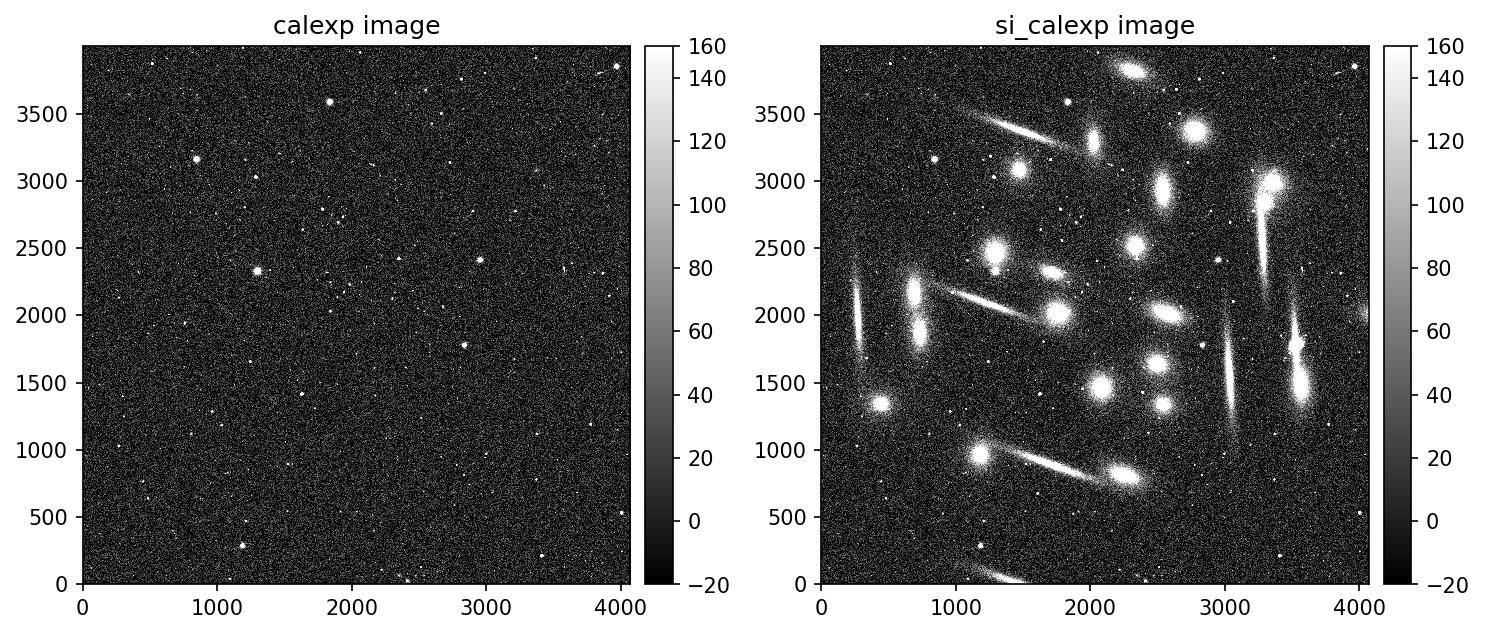

In [25]:
plot_si_calexp = injected_exposure.clone()

fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
# display0.scale('linear', 'zscale')
display0.scale('linear', min=-20, max=150)
display0.mtv(calexp_g.image)
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
# display1.scale('linear', 'zscale')
display1.scale('linear', min=-20, max=150)
display1.mtv(plot_si_calexp.image)
# To zoom on the NGC 4152 stamp:
# display1.mtv(plot_si_calexp.image[3300:3800, 1500:2000])
plt.title('si_calexp image')

plt.tight_layout()
plt.show()

### 4.2 Create a difference image to see the injected sources

One reason for injected sources into a `calexp` image might be to test whether they would be recovered in a difference image (i.e., the `calexp` with a deep, coadd template image of the same sky area appropriately convolved and subtracted from it). In this section we demonstrate the use of an image differencing task from the LSST Science Pipelines to create a difference image.

#### 4.2.1 Load the template image
Template images are created as coadds of the images with the best seeing, and are called `goodSeeingDiff_templateExp`. Load the appropriate template corresponding to our `calexp` (note the use of the same dataId we used to load the `calexp`).

In [26]:
difftemp = 'goodSeeingDiff_templateExp'
templateExposure = butler.get(difftemp, dataId=dataId_g.required)

#### 4.2.2 Initialize and run the image subtraction task

The first two lines below load the default configuration for the `AlardLuptonSubtract` task, and then initialize the task with that configuration. The task requires (1) a template exposure, (2) the science exposure, and (3) the catalog of sources from the science exposure.

Load the source catalog (`src`) and run the task:

In [27]:
config = AlardLuptonSubtractConfig()
alTask = AlardLuptonSubtractTask(config=config)

scienceExposure = injected_exposure

sources = butler.get('src', dataId=dataId_g)
result = alTask.run(templateExposure, scienceExposure, sources)

#### 4.2.3 Compare the original and the difference image

Plot the original `calexp`, the injected image, and the difference image side by side:

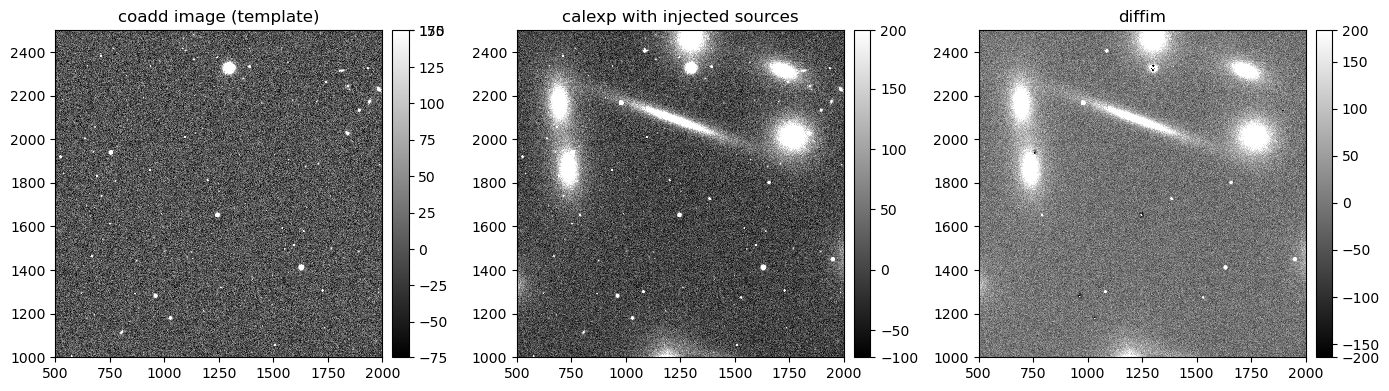

In [28]:
# Zoom in on an arbitrary section of the image.
# Change these coordinates to see a different region.
xmin, xmax = 500, 2000
ymin, ymax = 1000, 2500

fig, ax = plt.subplots(1, 3, figsize=(14, 11))
plt.sca(ax[0])  # set the first axis as current
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(calexp_g.image)
plt.title('coadd image (template)')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.sca(ax[1])  # set the second axis as current
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
display2.mtv(plot_si_calexp.image)
plt.title('calexp with injected sources')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.sca(ax[2])  # set the third axis as current
display3 = afwDisplay.Display(frame=fig)
display3.scale('linear', 'zscale')
display3.mtv(result.difference.image)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title('diffim')
plt.tight_layout()
plt.show()

## 5. Test recovery of injected stars

In this section we will again inject sources into a `calexp` image, and will then run the Science Pipelines tasks to detect and measure all sources in the image. We end by comparing the measurements of injected sources to their (known) properties from the injection catalog.

First, extract the minimum and maximum RA and Dec values of the `calexp` image to be used in generating a list of synthetic stars for injection.

In [29]:
corners = bbox.getCorners()
ra_corners = []
dec_corners = []

for c in corners:
    ra_corners.append(wcs.pixelToSky(c.x, c.y)[0])
    dec_corners.append(wcs.pixelToSky(c.x, c.y)[1])

minra = np.min(ra_corners).asDegrees()
maxra = np.max(ra_corners).asDegrees()
mindec = np.min(dec_corners).asDegrees()
maxdec = np.max(dec_corners).asDegrees()

### 5.1 Make a catalog of synthetic stars

This time we will demonstrate a different way to create the injection catalog. Instead of using `generate_injection_catalog`, we will directly create an Astropy Table containing the properties of stars to inject.

Set a variable "nstars" for the number of stars to create, then randomly generate arrays of RA, Dec positions and g-band magnitudes for that many stars.

In [30]:
nstars = 231
ras = np.random.uniform(low=minra, high=maxra, size=(nstars,))
decs = np.random.uniform(low=mindec, high=maxdec, size=(nstars,))
gmags = np.random.uniform(low=17.0, high=23.0, size=(nstars,))

Turn those arrays into a Table with the correct format to be ingested into the Butler as an `injection_catalog`.

Note that this time we use a `source_type` of "DeltaFunction" instead of "Star." Either is acceptable because the `source_injection` package defines "Star" as an alias for "DeltaFunction."

In [31]:
si_cat_stars_g = Table({'injection_id': np.arange(nstars),
                        'ra': ras, 'dec': decs,
                        'source_type': ['DeltaFunction']*nstars,
                        'mag': gmags,
                       })

In [32]:
si_cat_stars_g

injection_id,ra,dec,source_type,mag
int64,float64,float64,str13,float64
0,56.409877052256846,-36.39220487304507,DeltaFunction,20.64605427761851
1,56.68739728589655,-36.500997956760344,DeltaFunction,21.241028753565637
2,56.68538401023043,-36.361595819249985,DeltaFunction,18.905047800484287
3,56.38425013307732,-36.43206511082574,DeltaFunction,22.94326980838722
4,56.47194163481385,-36.54497450458861,DeltaFunction,18.235437550429108
5,56.740830272982755,-36.30778834316007,DeltaFunction,19.925856413577502
6,56.43005638658783,-36.30092387831261,DeltaFunction,22.71520137198658
7,56.413476852539745,-36.379226652877776,DeltaFunction,21.74685163815208
8,56.44195672956847,-36.31479602096475,DeltaFunction,17.37395379751451


### 5.2 Ingest the synthetic catalog into the Butler

In [33]:
INJECTION_CATALOG_COLLECTION2=f"u/{user}/test2_injection_inputs"

# Instantiate a writeable Butler.
writeable_butler =  Butler(butler_config, writeable=True)

try:
    writeable_butler.removeRuns([INJECTION_CATALOG_COLLECTION2])
except MissingCollectionError:
    print("Writing into a new RUN collection")
    pass
else:
    print("Prior RUN collection located and successfully removed")

# Ingest the injection catalog.
my_injected_datasetRefs_g = ingest_injection_catalog(
    writeable_butler=writeable_butler,
    table=si_cat_stars_g,
    band="g",
    output_collection=INJECTION_CATALOG_COLLECTION2,
)

Prior RUN collection located and successfully removed


### 5.3 Inject the stars into an image

First, load the injection catalogs that we just wrote to the Butler:

In [34]:
injection_refs2 = butler.registry.queryDatasets(
    "injection_catalog",
    band="g",
    collections=INJECTION_CATALOG_COLLECTION2,
)
injection_catalogs2 = [
    butler.get(injection_ref) for injection_ref in injection_refs2
]

Instantiate the injection class and run it:

In [35]:
# Instantiate the injection classes.
inject_config = VisitInjectConfig()
inject_task = VisitInjectTask(config=inject_config)

# Run the source injection task.
injected_output2 = inject_task.run(
    injection_catalogs=injection_catalogs2,
    input_exposure=calexp_g.clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)

injected_exposure2 = injected_output2.output_exposure
injected_catalog2 = injected_output2.output_catalog

### 5.4 Run detection and measurement tasks on the image with injected sources

The details of running source detection and measurement tasks from the pipelines on `calexp` images were covered in [tutorial notebook 05: Intro to Source Detection](https://github.com/rubin-dp0/tutorial-notebooks/blob/main/DP02_05_Introduction_to_Source_Detection.ipynb), so we do not describe the process in detail here. Instead, we wrapped all of the steps (characterization, detection, deblending, and measurement) in a function called `processInjected` defined above. This function takes as inputs the original `calexp`, and the `calexp` with injected sources, and returns a catalog of measurements for sources in the injected exposure.

Call the `processInjected` function to detect and measure sources in the injected image:

In [36]:
sources_withfakes_g = processInjected(injected_exposure2)

psf fwhm = 1.00 arcsec


In [37]:
sources_withfakes_g

id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_failed,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_near_edge,base_CircularApertureFlux_flag_badCentroid_near_edge,base_GaussianFlux_flag_badCentroid_near_edge,base_LocalBackground_flag_badCentroid_near_edge,base_NaiveCentroid_flag_badInitialCentroid_near_edge,base_PsfFlux_flag_badCentroid_near_edge,base_SdssShape_flag_badCentroid_near_edge,base_Variance_flag_badCentroid_near_edge,slot_Centroid_flag_near_edge,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFl

### 5.5 Compare the input and measured magnitudes of the injected stars

To do so, we must match the injection catalog with the measured catalog. We use the Astropy [SkyCoord](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) package to do the matching.

Create SkyCoord objects from the injection catalog and the measurements, then plot their coordinates to confirm they overlap on the sky.

In [38]:
# Coordinates of input fake stars
sc_fakes = SkyCoord(ra=si_cat_stars_g['ra']*u.deg, dec=si_cat_stars_g['dec']*u.deg, frame='icrs')

# Coordinates of objects in calexps with fakes added:
sc_withfakes_g = SkyCoord(ra=sources_withfakes_g['coord_ra'], dec=sources_withfakes_g['coord_dec'], frame='icrs')


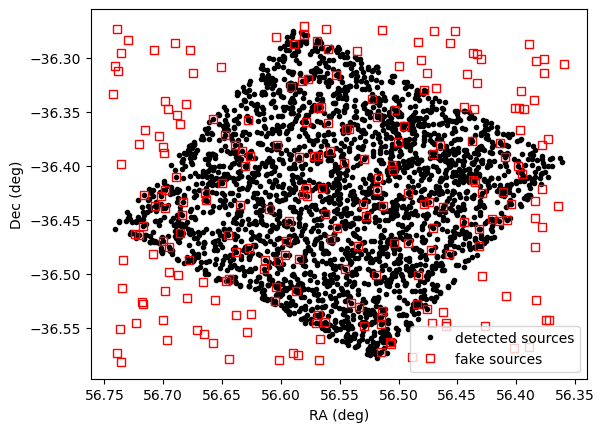

In [39]:
fig, ax = plt.subplots(1, 1)
plt.plot(sc_withfakes_g.ra, sc_withfakes_g.dec, '.k', label='detected sources')
plt.plot(sc_fakes.ra, sc_fakes.dec, 'sr', fillstyle='none', label='fake sources')
ax.invert_xaxis()
plt.legend()
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.show()

Match them using the Astropy SkyCoord `match_to_catalog_sky` method. When given two catalogs (say "cat1" and "cat2") this method returns the indices (as "idx_g" here) of matches to each "cat1" object in "cat2", and the separation between the matched objects. In the second cell below, select matches where the separation is less than 1.0 arcseconds.

In [40]:
idx_g, sep_g, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_g)

In [41]:
okmch_g = (sep_g.arcsec < 1.0)
mch_mags_g = sources_withfakes_g[idx_g]['mag_psf']
mch_magerrs_g = sources_withfakes_g[idx_g]['magerr_psf']
mch_mags_g[~okmch_g] = -99.9
mch_magerrs_g[~okmch_g] = 99.9
seps_g = sep_g.arcsec

#### 5.5.1 Compare the injected and measured magnitudes of stars

Now that we have matched the input and output catalogs, we can directly compare the recovered magnitudes of the injected stars. Plot the difference between the measured and "true" magnitudes vs. the "true" (injected) magnitude ($mag_{\rm fake}$):

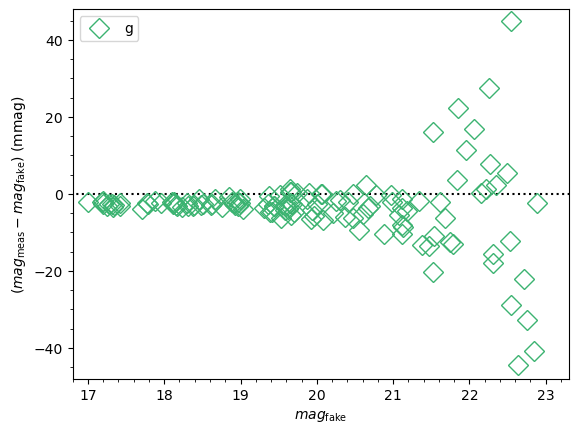

In [42]:
fig = plt.plot(figsize=(9, 9))

plt.hlines(0, 0, 30, linestyle=':', color='Black')
plt.plot(si_cat_stars_g[okmch_g]['mag'], 1000.0 * (mch_mags_g[okmch_g] - si_cat_stars_g[okmch_g]['mag']),
         'D', ms=10, color='mediumseagreen', label='g', fillstyle='none')
plt.legend()
plt.xlabel(r'$mag_{\rm fake}$')
plt.ylabel(r'$(mag_{\rm meas} - mag_{\rm fake})$ (mmag)')
plt.xlim(16.8, 23.3)
plt.ylim(-48, 48)
plt.minorticks_on()
plt.show()

The magnitude differences are very near, but not exactly at, zero (note that the offsets are plotted in _millimagnitudes_), with the errors increasing toward fainter injected magnitudes, as expected.

# 6. Exercises for the learner

Further explorations could include:
* Injecting sources into coadd images.
* Exploring other types of objects that can be injected into images (i.e., other Galsim parameters for more complicated sources).
* Injecting variable objects into multiple calexp images and testing their recoverability.